In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from fastai.data.all import *
from fastai.vision.all import *

import gc

In [2]:
# This patch is to display epoch results while using Visual Studio Code
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [6]:
class ConvNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16*7*7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [ ]:
# sets device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet(1, 10).to(device)

In [ ]:
# load data
train_data = datasets.MNIST(
    root='./datasets',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

test_data = datasets.MNIST(
    root='./datasets',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

In [ ]:
# sets hyperparameters
in_features = 784
num_classes = 10
learning_rate = 0.001
num_epochs = 5

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import time
import os

def save_checkpoint(states, output_dir=None):
    print('=> Saving checkpoints')
    if output_dir is None:
        output_dir = 'checkpoints'
        if output_dir not in os.listdir():
            os.makedirs(output_dir)
    elif output_dir not in os.listdir():
            os.makedirs(output_dir)
    output_file = 'checkpoint-' + str(time.time()) + '.pth.tar'
    output_file = os.path.join(output_dir, output_file)
    torch.save(states, output_file)


def save_best_model(states, output_dir=None, output_file=None):
    print('=> Saving best model')
    if output_dir is None:
        output_dir = 'best_models'
        os.makedirs(output_dir)
    elif output_dir not in os.listdir():
            os.makedirs(output_dir)
    if output_file is None:
        output_file = 'best_model.pth.tar'
    output = os.path.join(output_dir, output_file)
    torch.save(states, output)

In [ ]:
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Batch {}| Loss {}'.format(batch_idx, loss))
    
    states = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    save_checkpoint(states)


In [ ]:
checkpoint = torch.load('./checkpoints/checkpoint-1645412551.918868.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
def check_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            correct += (predictions == y).sum()
            total += predictions.size(0)
        model.train()
        print('Accuracy: ', correct/total)

In [ ]:
check_accuracy(test_loader, model)

# Pets Classification with Fastai
The Oxford IIIT Pets dataset is a dataset of pictures of dogs and cats, with $37$ different breeds. The images are now not all of the same size. Therefore, we will need to add something to make them all the same size to be able to assemble them together in a batch. We will also see how to add data augmentation. First we will download and decompress the dataset and get the path to the dataset.

In [3]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images')]

As you can see, the all the image files are in the `images` subfolder.

In [4]:
(path/"images").ls()

(#7393) [Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.mat'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.mat'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.mat'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg')...]

The `get_image_files` function helps get all the images in a folders.

In [5]:
fnames = get_image_files((path/'images'))
fnames

(#7390) [Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_105.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_106.jpg'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images/Abyssinian_107.jpg')...]

A `DataBlock` is just a blue print on how to assemble your data. It does not do anything until you pass it a source. You can choose to then convert that source into a `Datasets` or a `DataLoaders` by using the `DataBlock.datasets` or `DataBlock.dataloaders` method.

The first thing we can do is use a `get_items` function to actually assemble our items inside the data block.

In [6]:
dblock = DataBlock(
    get_items=get_image_files
)

Our inputs are ready to be processed as images since images can be built from filenames, but our target is not. Since we are in a cat versus dog problem, we need to convert that filename to “cat” vs “dog” (or True vs False). Let’s build a function for this. We can then tell our data block to use it to label our target by passing it as `get_y`.

In [7]:
def label_func(fname):
    return "cat" if fname.name[0].isupper() else "dog"

In [8]:
dblock = DataBlock(get_items = get_image_files,
                   get_y = label_func
)

Now that our inputs and targets are ready, we can specify types to tell the data block API that our inputs are images and our targets are categories. Types are represented by blocks in the data block API, here we use `ImageBlock` and `CategoryBlock`.

In [9]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = label_func
)

The next step is to control how our validation set is created. We do this by passing a splitter to DataBlock. For instance, here is how to do a random split. The last step is to specify item transforms and batch transforms.

In [11]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter = RandomSplitter(),
                   item_tfms=Resize(224)
)

Next, we just have to point the source of the data to the data block to create `Datasets` or `DataLoaders`.

In [12]:
dsets = dblock.datasets(path/"images")
print(dsets.train[0])
print(dsets.vocab)

(PILImage mode=RGB size=300x295, TensorCategory(0))
['cat', 'dog']


As we can see how the `DataBlock` automatically added the transforms necessary to open the image or how it changed the name “dog” to an index 1 (with a special tensor type TensorCategory(1)). To do this, it created a mapping from categories to the index called “vocab” that we can access this way.

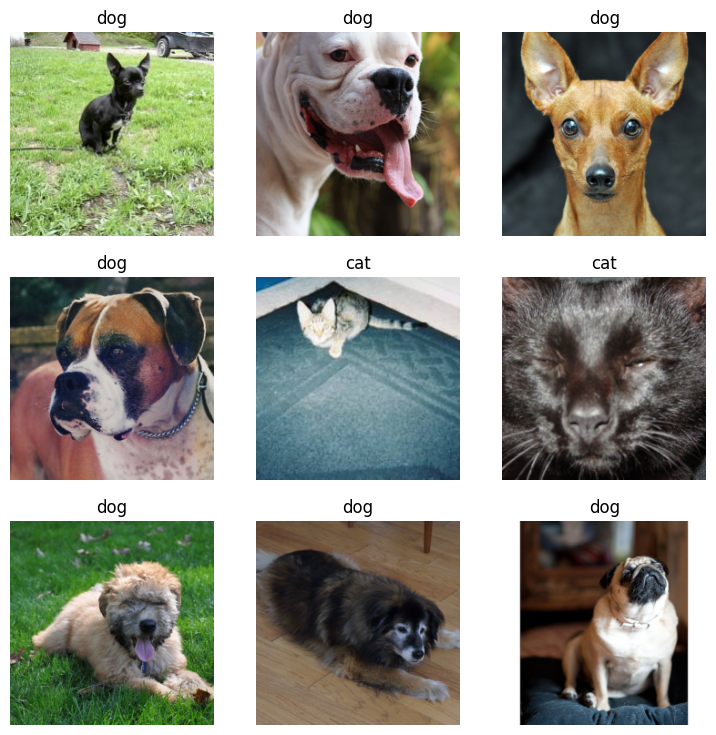

In [14]:
dls = dblock.dataloaders(path/"images")
dls.show_batch()

Next, we will try to extract the species of the pets using regular expression. `'(.+)_\d+.jpg$'` - This regular expression plucks out all the characters leading up to the last underscore character, as long as the subsequent characters are numerical digits and then the JPEG file extension. In addition, we will performing data augmentations.

In [15]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dls = pets.dataloaders(path/"images")

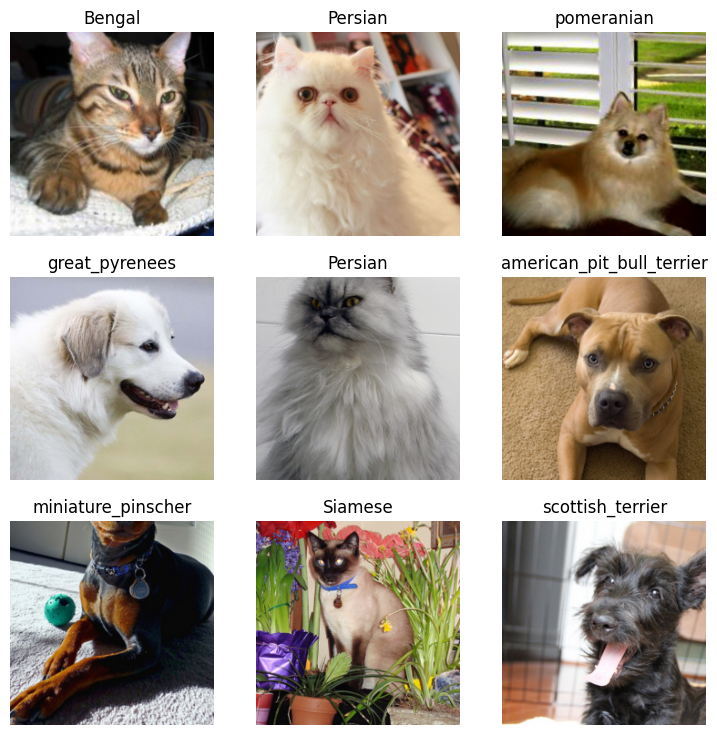

In [16]:
dls.show_batch()

In [17]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.512489,0.326110,0.105548,01:47
1,0.346157,0.208026,0.069689,01:50


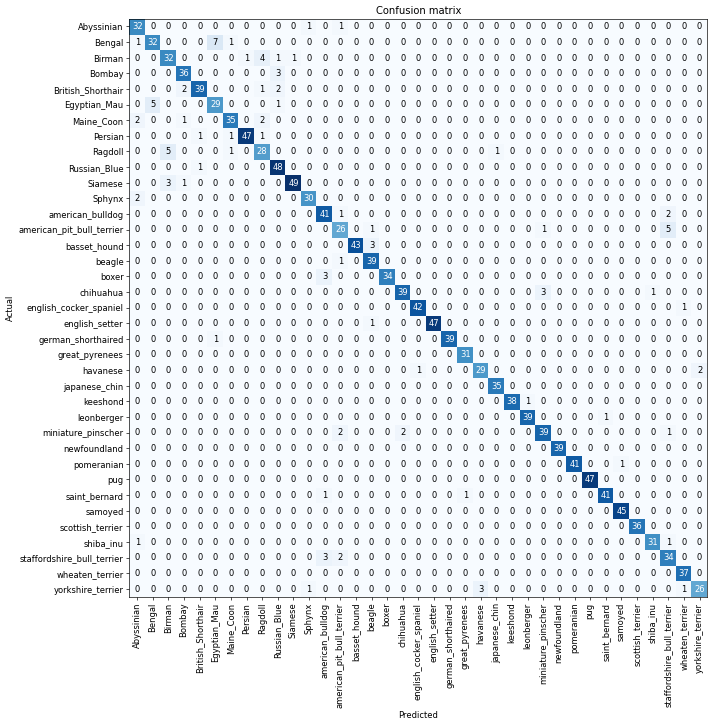

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

We can use the `most_confused` method, which just shows us the cells of the confusion matrix with the most incorrect predictions.

In [19]:
interp.most_confused(min_val=5)

[('Bengal', 'Egyptian_Mau', 7),
 ('Egyptian_Mau', 'Bengal', 5),
 ('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5)]

### Learning Rate Finder
One of the most important things we can do when training a model is to make sure that we have the right learning rate. If our learning rate is too low, it can take many, many epochs to train our model. Not only does this waste time, but it also means that we may have problems with overfitting, because every time we do a complete pass through the data, we give our model a chance to memorize it.

The Fast.ai library provides a useful tool called the "learning rate finder" to help determine an appropriate learning rate for training deep learning models. The learning rate finder implemented in Fast.ai follows a simple yet effective process. Here's how it typically works:

- **Model Initialization:** First, you need to define your deep learning model architecture using the Fast.ai library.
- **Learning Rate Range:** Next, you set a range of learning rates that you want to explore. Typically, you choose a broad range, spanning several orders of magnitude, such as 1e-7 to 10.
- **Training with Varying Learning Rates:** During this step, you train your model for a few epochs while gradually increasing the learning rate within the specified range. The model is trained on a subset of the data, often referred to as a "mini-batch," to speed up the process. The learning rate is updated using a cyclical or exponential schedule.
- **Batch Statistics:** While training, the learning rate finder keeps track of the loss values and the corresponding learning rates used for each mini-batch. It accumulates statistics such as the loss and the learning rate.
- **Plotting the Learning Rate Curve:** Once the training is complete, the learning rate finder provides a plot of the loss against the learning rate. The learning rate is typically plotted on a logarithmic scale. This curve is known as the "learning rate curve" or "LR curve."
- **Analyzing the Learning Rate Curve:** By examining the LR curve, you can identify the optimal learning rate range. The curve typically exhibits a characteristic shape: initially, the loss decreases slowly, then it drops rapidly, and finally, it starts to increase again. The optimal learning rate is usually selected from the steepest descending part of the curve, just before the loss starts to rise.
- **Setting the Learning Rate:** Based on the LR curve analysis, you can manually set the learning rate for your subsequent training runs. You might choose a value slightly before the loss starts to increase, ensuring that the model progresses in the descending part of the curve.

Our advice is to pick either of these:
- One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
- The last point where the loss was clearly decreasing

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min}")

We can see on this plot that in the range $1e^{-6}$ to $1e^{-3}$, nothing really happens and the model doesn’t train. Then the loss starts to decrease until it reaches a minimum, and then increases again. We don’t want a learning rate greater than $1e^{-1}$, as it will cause training to diverge (you can try for yourself), but $1e^{-1}$ is already too high: at this stage, we’ve left the period where the loss was decreasing steadily.

The learning rate finder plot has a logarithmic scale, which is why the middle point between $1e^{-3}$ and $1e^{-2}$ is between $3e^{-3}$ and $4e^{-3}$. This is because we care mostly about the order of magnitude of the learning rate.

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

### Transfer Learning
We now know that a convolutional neural network consists of many linear layers with a nonlinear activation function between each pair, followed by one or more final linear layers with an activation function such as softmax at the very end. The final linear layer uses a matrix with enough columns such that the output size is the same as the number of classes in our model (assuming that we are doing classification).

This final linear layer is unlikely to be of any use for us when we are fine-tuning in a
transfer learning setting, because it is specifically designed to classify the categories in the original pretraining dataset. So when we do transfer learning, we remove it, throw it away, and replace it with a new linear layer with the correct number of outputs for our desired task (in this case, there would be 37 activations). This newly added linear layer will have entirely random weights. Therefore, our
model prior to fine-tuning has entirely random outputs. But that does not mean that it is an entirely random model! All of the layers prior to the last one have been carefully trained to be good at image classification tasks in general.

We want to train a model in such a way that we allow it to remember all of these generally useful ideas from the pretrained model, use them to solve our particular task (classify pet breeds), and adjust them only as required for the specifics of our particular task. Our challenge when fine-tuning is to replace the random weights in our added linear layers with weights that correctly achieve our desired task (classifying pet breeds) without breaking the carefully pretrained weights and the other layers.

A simple trick can allow this to happen: tell the optimizer to update the weights in only those randomly
added final layers. Don’t change the weights in the rest of the neural network at all. This is called freezing those pretrained layers. When we create a model from a pretrained network, fastai automatically freezes all of the pretrained layers for us. When we call the `fine_tune` method, fastai does two
things:
- Trains the randomly added layers for one epoch, with all other layers frozen
- Unfreezes all the layers, and trains them for the number of epochs requested

Although this is a reasonable default approach, it is likely that for your particular dataset, you may get better results by doing things slightly differently. The `fine_tune` method has parameters you can use to change its behavior, but it might be easiest for you to just call the underlying methods directly if you want to get custom behavior.

So let’s try doing this manually ourselves. First of all, we will train the randomly added layers for three epochs, using `fit_one_cycle`. `fit_one_cycle` is the suggested way to train models without using `fine_tune`. In short, what `fit_one_cycle` does is to start training at a low learning rate, gradually increase it for the first section of training, and then gradually decrease it again for the last section of training.

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

Then we’ll unfreeze the model.

In [ ]:
learn.unfreeze()

Run `lr_find` again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn’t appropriate anymore.

In [ ]:
learn.lr_find()

Note that the graph is a little different from when we had random weights: we don’t have that sharp descent that indicates the model is training. That’s because our model has been trained already. Here we have a somewhat flat area before a sharp increase, and we should take a point well before that sharp increase—for instance, $1e{-5}$.

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

This has improved our model a bit, but there’s more we can do. The deepest layers of our pretrained model might not need as high a learning rate as the last ones, so we should probably use different learning rates for those—this is known as using **discriminative learning rates**.

### Discriminative Learning Rate
Even after we unfreeze, we still care a lot about the quality of those pretrained weights. We would not expect that the best learning rate for those pretrained parameters would be as high as for the randomly added parameters, even after we have tuned those randomly added parameters for a few epochs. Remember, the pretrained weights have been trained for hundreds of epochs, on millions of images.

The first layer learns very simple foundations, like edge and gradient detectors; these are likely to be just as useful for nearly any task. The later layers learn much more complex concepts, like “eye” and “sunset,” which might not be useful in your task at all (maybe you’re classifying car models, for instance). So it makes sense to let the later layers fine-tune more quickly than earlier layers.

Therefore, fastai’s default approach is to use discriminative learning rates. Like many good ideas in deep learning, it is extremely simple: use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers.

fastai lets you pass a Python `slice` object anywhere that a learning rate is expected. The first value passed will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range. Let’s use this approach to replicate the previous training, but this time we’ll set only the lowest layer of our net to a learning rate of $1e^{-6}$; the other layers will scale up to $1e^{-4}$. Let’s train for a while and see what happens.

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

fastai can show us a graph of the training and validation loss.

In [ ]:
learn.recorder.plot_loss()

As you can see, the training loss keeps getting better and better. But notice that eventually the validation loss improvement slows and sometimes even gets worse! This is the point at which the model is starting to overfit. In particular, the model is becoming overconfident of its predictions. But this does not mean that it is getting less accurate, necessarily. Take a look at the table of training results per epoch, and you will often see that the accuracy continues improving, even as the validation loss gets worse. In the end, what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we’ve given the computer to help us to optimize.

### Deeper Architectures
A bigger model has the ability to better capture the real underlying relationships in your data, as well as to capture and memorize the specific details of your individual images. However, using a deeper model is going to require more GPU RAM, so you may need to lower the size of your batches to avoid an out-of-memory error. This happens when you try to fit too much inside your GPU.

One technique that can speed things up a lot is mixed-precision training. This refers to using less-precise numbers (half-precision floating point, also called fp16) where possible during training. As we are writing these words in early 2020, nearly all current NVIDIA GPUs support a special feature called tensor cores that can dramatically speed up neural network training, by $2–3\times$. They also require a lot less GPU memory. To enable this feature in fastai, just add `to_fp16()` after your Learner creation.

In [ ]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(3, freeze_epochs=3)

We can pass `freeze_epochs` to tell `fine_tune` how many epochs to train for while frozen. It will automatically change learning rates appropriately for most datasets.